## MLFlow avec TensorFlow 2.0



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score
import mlflow
import mlflow.tensorflow
print("TensorFlow: {}".format(tf.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("Numpy: {}".format(np.__version__))
print("MLFlow: {}".format(mlflow.__version__))
print("Matplotlib: {}".format(matplotlib.__version__))

In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.15.0-cp39-cp39-win_amd64.whl (2.1 kB)
  Using cached protobuf-4.25.1-cp39-cp39-win_amd64.whl (413 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.2
    Uninstalling protobuf-3.20.2:
      Successfully uninstalled protobuf-3.20.2
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\PC\\AppData\\Roaming\\Python\\Python39\\site-packages\\google\\~-otobuf\\internal\\_api_implementation.cp39-win_amd64.pyd'
Check the permissions.

You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


In [16]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Class:  5


(<matplotlib.image.AxesImage at 0x1e4f1d1bc10>, None)

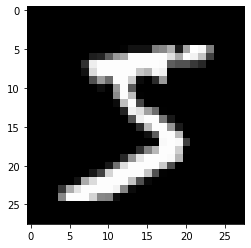

In [17]:
# pour avoir un aperçu sur le dataset
plt.imshow(x_train[0], cmap='gray'), print("Class: ", y_train[0])

Notez également que les étiquettes sont toutes des nombres entiers compris entre 0 et 9, chacune associée à une image qui montre un chiffre manuscrit de 0 à 9. 

Étant donné que les couches convolutives 2D dans TensorFlow/Keras s'attendent à quatre dimensions au format (m, h, w, c) où m représente le nombre d'échantillons dans l'ensemble de données, h et w représentent respectivement la hauteur et la largeur, et c représente le nombre de canaux (trois s'il s'agit d'une image couleur RGB par exemple), vous devez remodeler vos données afin qu'elles soient conformes à ces spécifications. Vos images sont toutes en noir et blanc, elles en ont donc techniquement 1 canal. Et donc, vous devez les remodeler comme ceci : 

In [18]:
y_train[0]

5

In [20]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],
x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],
x_test.shape[2], 1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [21]:
y_train[0] # this is a one-hot encoded vector, ntice that at index 5 the value is 5

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [22]:
print("Shapes")
print("x_train: {}\ny_train: {}".format(x_train.shape,
y_train.shape))
print("x_test: {}\ny_test: {}".format(x_test.shape,
y_test.shape))

Shapes
x_train: (60000, 28, 28, 1)
y_train: (60000, 10)
x_test: (10000, 28, 28, 1)
y_test: (10000, 10)


### MLFlow run - training and evaluating 

Nous allons créer notre modèle en utilisant la méthode séquentielle de création de modèle. Le modèle sera assez simple,
composé de quelques couches convolutives 2D qui alimentent trois couches denses. 

In [23]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, strides=2,padding='same', input_shape=(28, 28, 1), activation="relu"))
model.add(Conv2D(filters=8, kernel_size=3, strides=2,padding='same', input_shape=(28, 28, 1), activation="relu"))
model.add(Flatten())
model.add(Dense(30, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 30)                11790     
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 13,940
Trainable params: 13,940
Non-traina

In [25]:
# nous allons compiler notre modèle en utilisant adam optimizer 
model.compile(optimizer="Adam",loss="categorical_crossentropy", metrics=["accuracy"])

Nous allons maintenant dire à MLFlow de loger ce run. nous souhaitons que toutes les métriques soient enregistrées dans la même exécution, vous devez donc indiquer spécifiquement à MLFlow d'exécuter un bloc de code dans le contexte de la même exécution. 

In [26]:
mlflow.set_experiment("TF_Keras_MNIST")
with mlflow.start_run():
    mlflow.tensorflow.autolog()
    model.fit(x=x_train, y=y_train, batch_size=256, epochs=10)
    preds = model.predict(x_test)
    preds = np.round(preds)
    eval_acc = model.evaluate(x_test, y_test)[1]
    auc_score = roc_auc_score(y_test, preds)
    print("eval_acc: ", eval_acc)
    print("auc_score: ", auc_score)
    mlflow.tensorflow.mlflow.log_metric("eval_acc", eval_acc)
    mlflow.tensorflow.mlflow.log_metric("auc_score", auc_score)
mlflow.end_run()

INFO: 'TF_Keras_MNIST' does not exist. Creating a new experiment


2021/11/14 16:07:21 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Epoch 1/10
235/235 [==============================] - 3s 12ms/step - loss: 1.8146 - accuracy: 0.6001
Epoch 2/10
235/235 [==============================] - 3s 12ms/step - loss: 0.3289 - accuracy: 0.9048
Epoch 3/10
235/235 [==============================] - 3s 12ms/step - loss: 0.1985 - accuracy: 0.9416
Epoch 4/10
235/235 [==============================] - 3s 12ms/step - loss: 0.1450 - accuracy: 0.9574
Epoch 5/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1140 - accuracy: 0.9652
Epoch 6/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0919 - accuracy: 0.9724
Epoch 7/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0771 - accuracy: 0.9771
Epoch 8/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0672 - accuracy: 0.9796
Epoch 9/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0585 - accuracy: 0.9822
Epoch 10/10
235/235 [==============================] - 3s 12ms/step - loss: 0.0509 - accura

la ligne mlflow.keras.autolog() 

Cela indique essentiellement à MLFlow d'enregistrer tous les paramètres et métriques associés au modèle TensorFlow/Keras. Comme vous le verrez dans peu de temps, MLFlow enregistrera les hyperparamètres, les métriques du modèle répertoriées dans la fonction compile() et même le modèle lui-même une fois l'entraînement terminé. 

### MLFlow UI 

ouvrons maintenant l'interface utilisateur de MLFlow et vérifions notre run. Assurez-vous que votre terminal ou invite de commande se trouve dans le même répertoire que celui où les mlruns sont stockés.

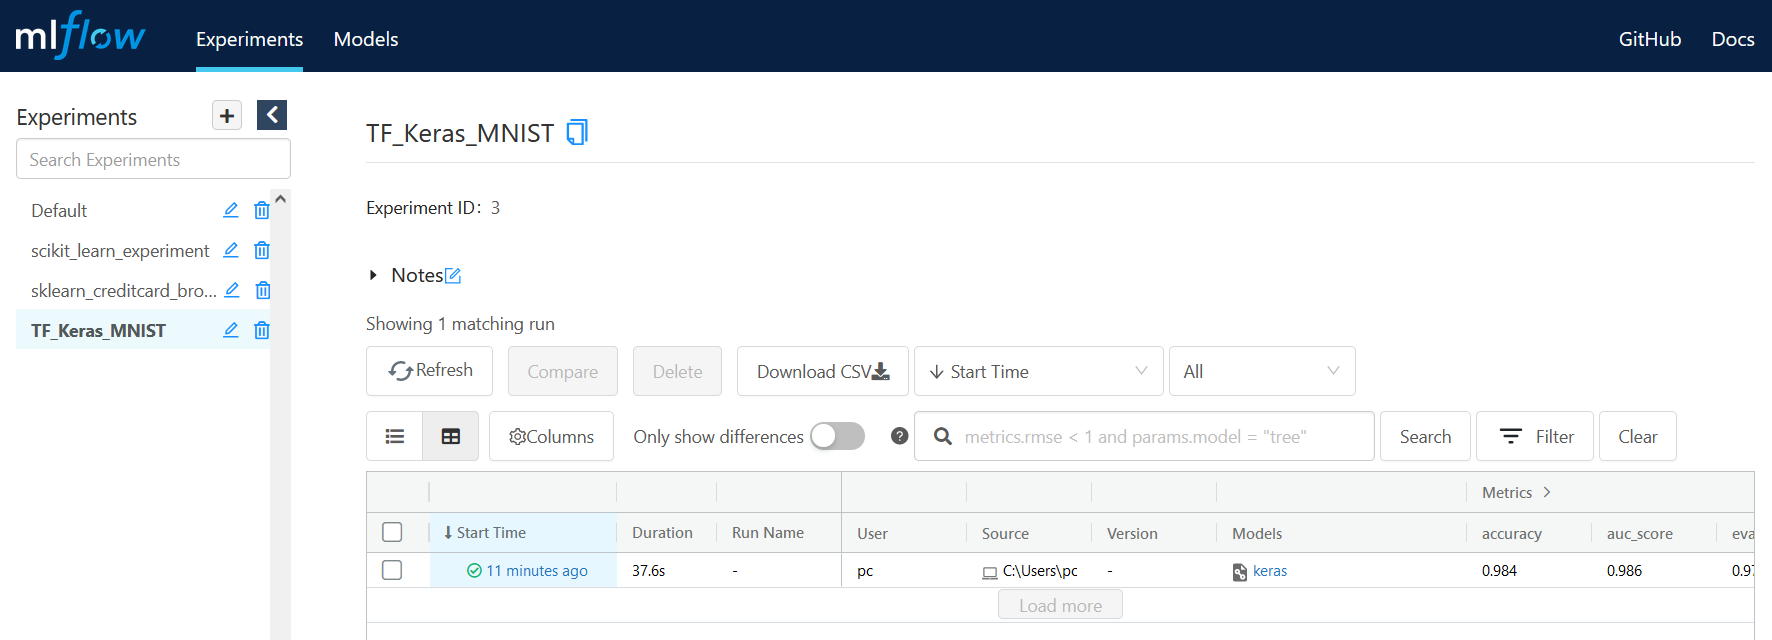

En cliquant sur le run, vous allez remarqué que MLFlow a enregistré tous les hyperparamètres utilisés lors de la création du modèle. Cela peut être très utile pour le réglage des hyperparamètres sur un ensemble de validation, par exemple, lorsque vous essayez de régler plusieurs hyperparamètres à la fois. Par exemple, vous pouvez certainement régler batch_size, epochs ou quelque chose lié à l'optimiseur Adam comme opt_learning_rate, opt_beta_1 ou opt_beta_2. 

Dans la partie artifacts en bas, vous allez remqrquer que MLflow a enregistré le modèle aussi, l'évnement Tensorboard et le summary du modèle 

### Model loading 

copiez l'ID du run 

In [27]:
loaded_model = mlflow.keras.load_model("runs:/8cff908c2db5441aa1993fe5c1161e4e/model")

Vous remarquerez que nous avons fait mlflow.keras au lieu de mlflow.tensorflow. C'est parce que ce modèle est techniquement un modèle Keras, et donc il est conforme au code load_model() spécifique dans le module mlflow.keras. 

In [28]:
eval_loss, eval_acc = loaded_model.evaluate(x_test, y_test)
preds = loaded_model.predict(x_test)
preds = np.round(preds)
eval_auc = roc_auc_score(y_test, preds)
print("Eval Loss:", eval_loss)
print("Eval Acc:", eval_acc)
print("Eval AUC:", eval_auc)

313/313 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.97 - 1s 3ms/step - loss: 0.0888 - accuracy: 0.9758
Eval Loss: 0.08881716430187225
Eval Acc: 0.9757999777793884
Eval AUC: 0.9858297428765951


Comme vous pouvez le voir, cette sortie correspond aux valeurs de la sortie de l'exécution précédente. De plus, ce modèle est également fonctionnel et peut faire des prédictions. 